<a href="https://colab.research.google.com/github/Nithinps021/DeepLearning/blob/master/hands__on_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH='datasets/housing'
HOUSING_URL=DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path=os.path.join(housing_path,'housing.tgz')
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path='sample_data/'+housing_path)
  housing_tgz.close()
  
fetch_data()


In [61]:
import pandas as pd

def loadHousingData(housing_path='sample_data/'+HOUSING_PATH):
  path_housing_csv=os.path.join(housing_path,'housing.csv')
  return pd.read_csv(path_housing_csv)

In [86]:
housingData=loadHousingData()
housingData=housingData[housingData['ocean_proximity']!='ISLAND']
housingData.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20635.000000,20635.000000,20635.000000,20635.000000,20428.000000,20635.000000,20635.000000,20635.000000,20635.000000
mean,-119.569999,35.632412,28.636152,2636.020208,537.899305,1425.660286,499.593700,3.870944,206813.756288
std,2.003685,2.135918,12.583924,2181.794772,421.425970,1132.530137,382.357072,1.899961,115372.499511
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1448.000000,296.000000,787.000000,280.000000,2.563100,119600.000000
50%,-118.500000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.535200,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743700,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [87]:
housingData.columns
# housingData["median_income"].value_counts()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17f9114668>,
      dtype=object)

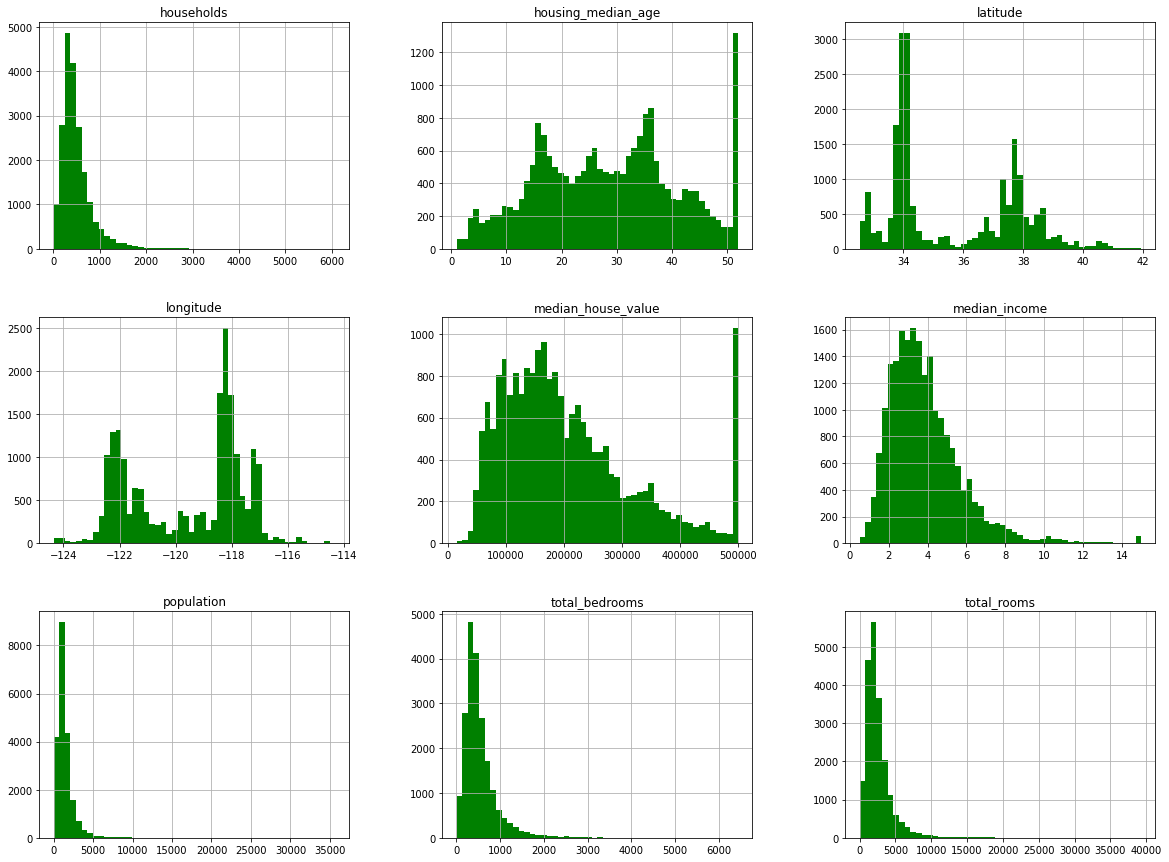

In [88]:
import matplotlib.pyplot as plt

housingData.hist(bins=50,figsize=(20,15),color='green')
# plt.show()

In [89]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit


# def shuffle_data(data,testSize):
#   shuffled_indices=np.random.permutation(len(data))
#   test_size=int(len(data)*testSize)
#   test_indices=shuffled_indices[:test_size]
#   train_indices=shuffled_indices[test_size:]
#   return data.iloc[test_indices] ,  data.iloc[train_indices]

# testData,trainData = shuffle_data(housingData,0.2)

# using sklearn train_test_split method

# from sklearn.model_selection import train_test_split
# train_data, test_data=train_test_split(housingData,test_size=0.2,random_state=42)

# print(len(train_data),len(test_data))


# StratifiedShuffleSplit

housingData['income_cat']=np.ceil(housingData['median_income']/1.5)
housingData['income_cat'].where(housingData['income_cat']<5,5.0,inplace=True)
splitData=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for trainIndex,testIndex in splitData.split(housingData,housingData['income_cat']):
  train_data=housingData.iloc[trainIndex]
  test_data=housingData.iloc[testIndex]
for  i in (train_data,test_data):
  i.drop(['income_cat'],axis=1,inplace=True)
housingData=train_data.copy()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


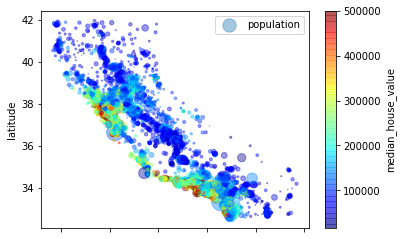

In [90]:

housingData.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
                 s=housingData['population']/100,label='population',
                 c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True
                 )
plt.legend()

In [91]:
# correlation matrix
cor_matrix=housingData.corr()
cor_matrix['median_income'].sort_values(ascending=False)

median_income         1.000000
median_house_value    0.688785
total_rooms           0.196893
households            0.007768
population           -0.000683
total_bedrooms       -0.012443
longitude            -0.019279
latitude             -0.075998
housing_median_age   -0.110781
Name: median_income, dtype: float64

In [92]:
# separating training data and training labels

housingData=train_data.drop(['median_house_value'],axis=1)
housingLabel=train_data['median_house_value'].copy()
  

In [93]:
# data cleaning using pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,LabelBinarizer,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion

rooms,bedrooms,population,household=3,4,5,6

class CombineAttribute(BaseEstimator,TransformerMixin):
  def __init__(self,add_bedroom_per_room=True):
    self.add_bedroom_per_room=add_bedroom_per_room
  def fit(self,X,Y=None):
    return self
  def transform(self,X,Y=None):
    rooms_per_household=X[:,rooms]/X[:,household]
    population_per_household=X[:,population]/X[:,household]
    if self.add_bedroom_per_room:
      bedroom_per_room=X[:,bedrooms]/X[:,rooms]
      print("all added")
      return np.c_[X,bedroom_per_room,rooms_per_household,population_per_household]
    else:
      return np.c_[X,rooms_per_household,population_per_household]

class DataFrameSelector(BaseEstimator,TransformerMixin):
  def __init__(self,attribute_names):
    self.attribute_names=attribute_names
  def fit(self,X,Y=None):
    return self
  def transform(self,X,Y=None):
    return X[self.attribute_names].values
    
class CatBinarlabelizer(BaseEstimator,TransformerMixin):
  def __init__(self):
    self.encoder=LabelBinarizer()
  def fit(self,X,Y=None):
    self.encoder.fit(X)
    return self
  def transform(self,X,Y=None):
    return self.encoder.transform(X)

housing_num=housingData.drop("ocean_proximity",axis=1)
attributes=list(housing_num)
catAttribute=['ocean_proximity']

num_pipeline=Pipeline([
                       ('selector',DataFrameSelector(attributes)),
                       ('impute',SimpleImputer(strategy='median')),
                       ('attribue_adder',CombineAttribute()),
                       ('normalise',StandardScaler())
])


cat_pipeline=Pipeline([
                       ('selector',DataFrameSelector(catAttribute)),
                       ('labelBinarizer',CatBinarlabelizer())
])

combinePipeline=FeatureUnion(transformer_list=[
                                               ('num_pipeline',num_pipeline),
                                               ('cat_pipeline',cat_pipeline)
])

housingTraining=combinePipeline.fit_transform(housingData)
housingTraining.shape

all added


(16508, 15)

In [ ]:
# data cleaning


# imputer=SimpleImputer(strategy='median')
# housing_num=housingData.drop("ocean_proximity",axis=1)
# imputer.fit(housing_num)
# X=imputer.transform(housing_num)
# housing_tr=pd.DataFrame(X,columns=housing_num.columns)
# norm=StandardScaler()
# normalised=norm.fit_transform(housing_tr)
# housing_num[number].values


In [ ]:
# text and categorical attributes

# housing_cat=housingData['ocean_proximity']

# # encoder=LabelEncoder()
# # housing_cat_encode=encoder.fit_transform(housing_cat)
# # hotEncoder=OneHotEncoder()
# # housing_cat_1hot=hotEncoder.fit_transform(housing_cat_encode.reshape(-1,1))
# # housing_cat_1hot.toarray()

# encoder=LabelBinarizer()
# housing_cat_1hot=encoder.fit_transform(housing_cat)
# housing_cat_1hot


In [98]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()
lin_reg.fit(housingTraining,housingLabel)
some_data=housingData.iloc[:50]
some_data_to_predic=combinePipeline.fit_transform(some_data)
some_label=housingLabel.iloc[:50].values
some_data_to_predic
predicted_values=lin_reg.predict(some_data_to_predic)
print(predicted_values[:5],'\n',some_label[:5])

all added
[ 86372.53697925 131947.34509332 220700.65251846 177722.57285662
 156262.98782268] 
 [ 94400. 145500. 200000. 199100. 111800.]
